In [ ]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SpatialDropout2D
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
%matplotlib inline
from zipfile import ZipFile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/archive (11).zip"

Archive:  /content/drive/MyDrive/archive (11).zip
  inflating: ph2_resized2/trainx/X_img_0.bmp  
  inflating: ph2_resized2/trainx/X_img_1.bmp  
  inflating: ph2_resized2/trainx/X_img_10.bmp  
  inflating: ph2_resized2/trainx/X_img_100.bmp  
  inflating: ph2_resized2/trainx/X_img_101.bmp  
  inflating: ph2_resized2/trainx/X_img_102.bmp  
  inflating: ph2_resized2/trainx/X_img_103.bmp  
  inflating: ph2_resized2/trainx/X_img_104.bmp  
  inflating: ph2_resized2/trainx/X_img_105.bmp  
  inflating: ph2_resized2/trainx/X_img_106.bmp  
  inflating: ph2_resized2/trainx/X_img_107.bmp  
  inflating: ph2_resized2/trainx/X_img_108.bmp  
  inflating: ph2_resized2/trainx/X_img_109.bmp  
  inflating: ph2_resized2/trainx/X_img_11.bmp  
  inflating: ph2_resized2/trainx/X_img_110.bmp  
  inflating: ph2_resized2/trainx/X_img_111.bmp  
  inflating: ph2_resized2/trainx/X_img_112.bmp  
  inflating: ph2_resized2/trainx/X_img_113.bmp  
  inflating: ph2_resized2/trainx/X_img_114.bmp  
  inflating: ph2_resized2

#Loading the data

In [ ]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [ ]:
filelist_trainx = sorted(glob.glob('/content/trainx/*'), key=numericalSort)

X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('/content/trainy/*'), key=numericalSort)

Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

#Splitting the dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 101)

#Plotting

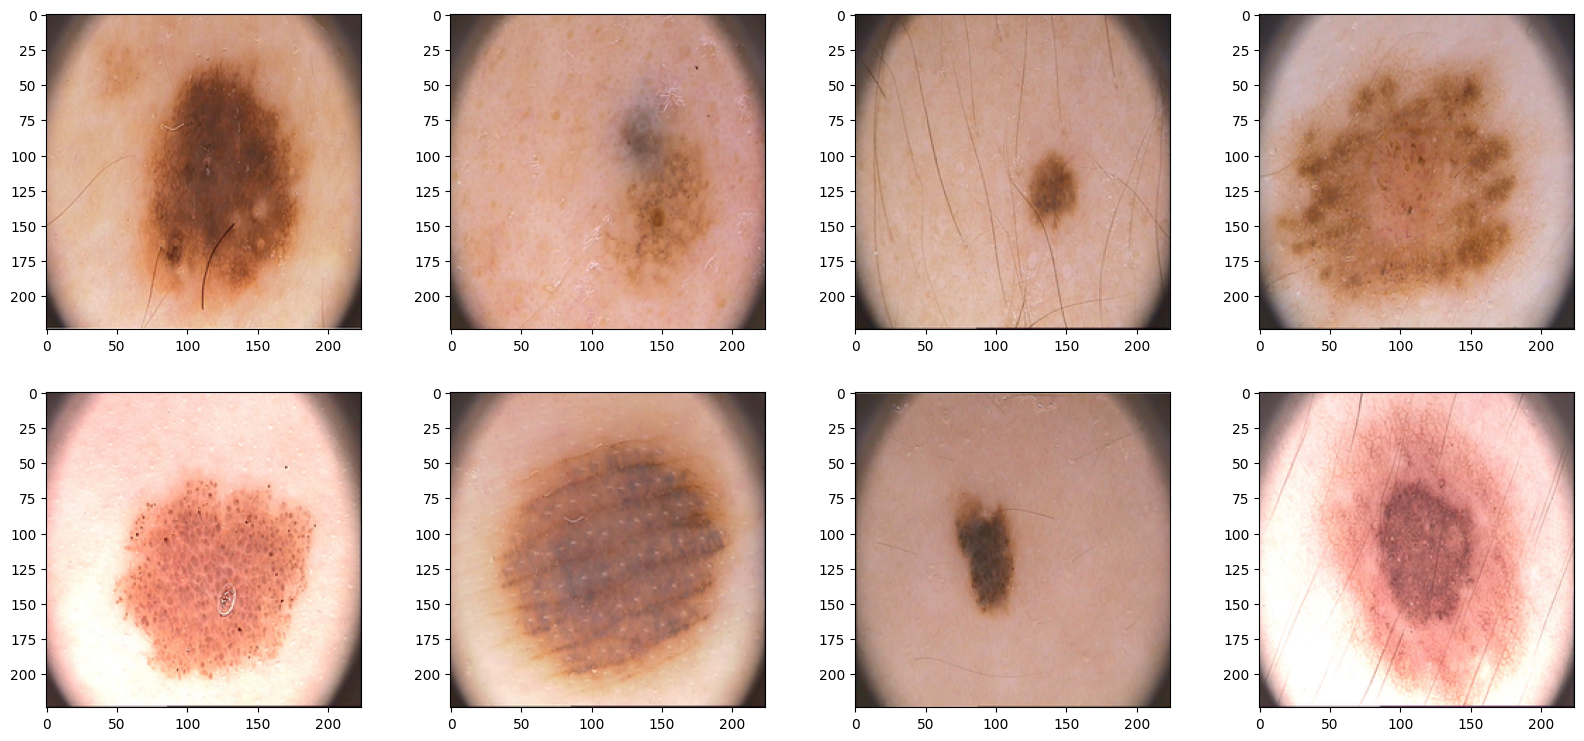

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(X_train[0])
plt.subplot(2,4,2)
plt.imshow(X_train[3])
plt.subplot(2,4,3)
plt.imshow(X_train[54])
plt.subplot(2,4,4)
plt.imshow(X_train[77])
plt.subplot(2,4,5)
plt.imshow(X_train[100])
plt.subplot(2,4,6)
plt.imshow(X_train[125])
plt.subplot(2,4,7)
plt.imshow(X_train[130])
plt.subplot(2,4,8)
plt.imshow(X_train[149])
plt.show()

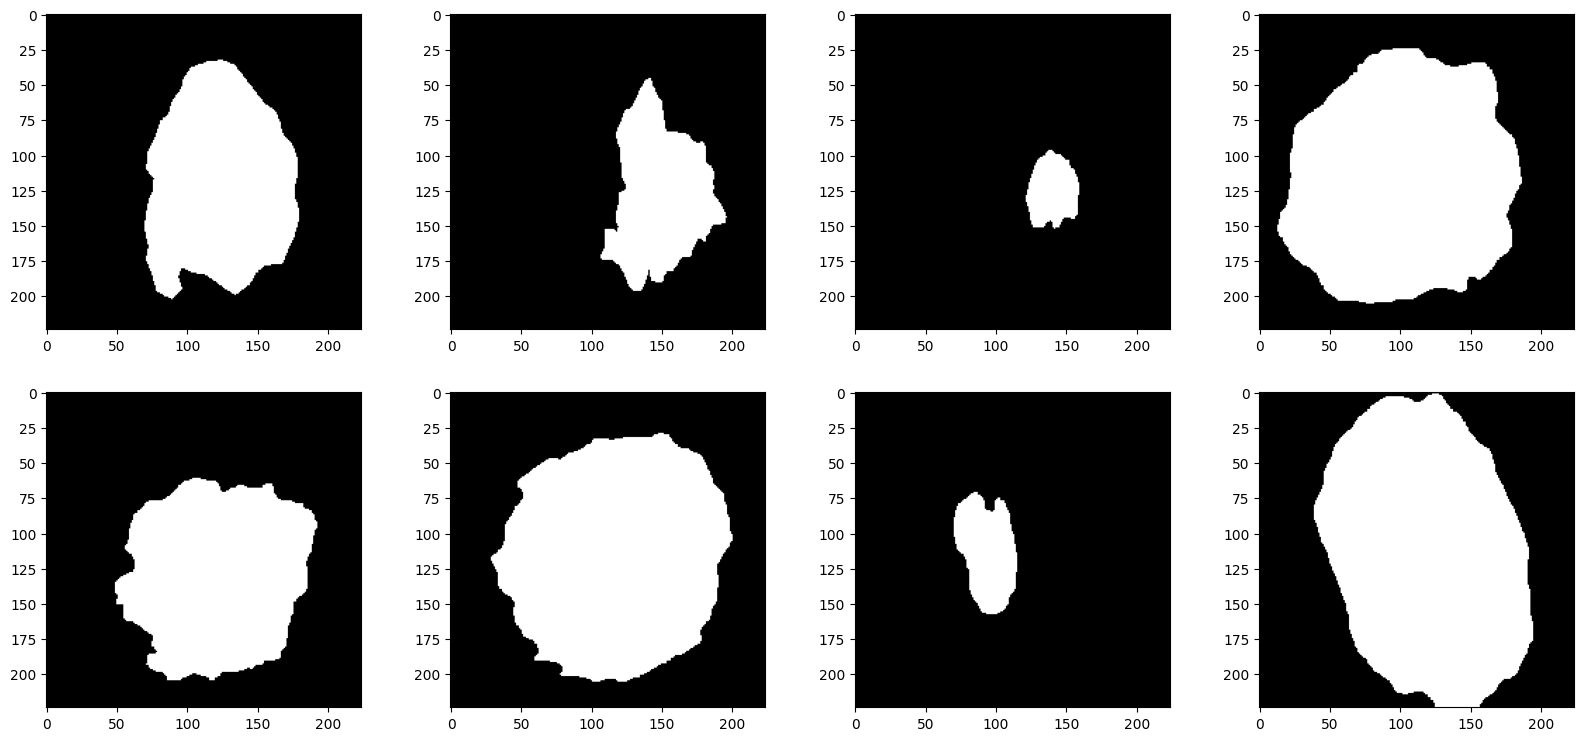

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(Y_train[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(Y_train[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(Y_train[54], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(Y_train[77], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(Y_train[100], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(Y_train[125], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(Y_train[130], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(Y_train[149], cmap = plt.cm.binary_r)
plt.show()

#Defining the loss function

###Jaccard

In [ ]:
import keras.backend as K

def jaccard_distance(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(K.cast(y_true, 'float32') * y_pred), axis=-1)
    sum_ = K.sum(K.square(K.cast(y_true, 'float32')), axis=-1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)


#Evaluation metrics

###Intersection over union

In [ ]:
import keras.backend as K

def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou


###Dice coeff

In [ ]:
def dice_coeff(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1)
    dice = (2.0 * intersection + smooth) / (union + intersection + smooth)
    return dice


###Precision

In [ ]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision



###Recall

In [ ]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (actual_positives + K.epsilon())
    return recall

##Accuracy

In [ ]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

#Augumentation

In [ ]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [ ]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [ ]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)

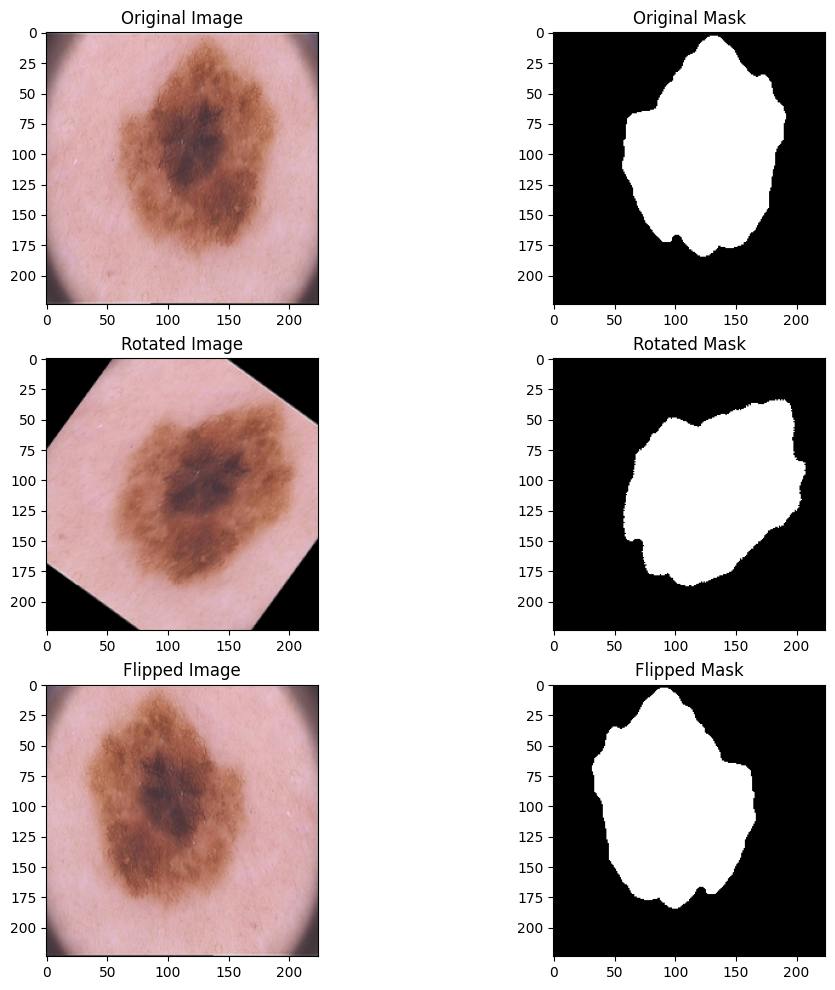

In [ ]:
img_num = 7
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

In [ ]:
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

#Validation

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [ ]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 360
Length of the Test Set       : 50
Length of the Validation Set : 90


# U_NET Model

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.layers import Activation, BatchNormalization, SpatialDropout2D
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Reshape
from keras.callbacks import EarlyStopping


In [ ]:
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights

In [ ]:
def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv

def UNET_224(epochs_num, savename):
    dropout_val = 0.50
    inputs = Input((224, 224, INPUT_CHANNELS))
    axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((224,224))(conv_final)
    model = Model(inputs, pred, name="UNET_224")
    model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coeff, precision, recall, accuracy])
    model.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    hist = model.fit(x_train, y_train, epochs=epochs_num, batch_size=18,
                     validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

    model.save(savename)
    return model, hist

# Call the UNET_224 function with appropriate arguments
model, hist = UNET_224(1, 'unet_1_epoch.h5')


Model: "UNET_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_184 (Conv2D)         (None, 224, 224, 32)         896       ['input_9[0][0]']             
                                                                                                  
 batch_normalization_176 (B  (None, 224, 224, 32)         128       ['conv2d_184[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_184 (Activation  (None, 224, 224, 32)         0         ['batch_normalization_1

In [ ]:
model, hist = UNET_224(1, 'unet_1_epoch.h5')



Model: "UNET_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_207 (Conv2D)         (None, 224, 224, 32)         896       ['input_10[0][0]']            
                                                                                                  
 batch_normalization_198 (B  (None, 224, 224, 32)         128       ['conv2d_207[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_207 (Activation  (None, 224, 224, 32)         0         ['batch_normalization_1

In [ ]:
dropout_val=0.50
if K.image_data_format()== 'channels_first':
    inputs = Input((INPUT_CHANNELS, 224, 224))
    axis = 1
else:
    inputs = Input((224, 224, INPUT_CHANNELS))
    axis = 3
filters = 32

conv_224 = double_conv_layer(inputs, filters)
pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

conv_112 = double_conv_layer(pool_112, 2*filters)
pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

conv_56 = double_conv_layer(pool_56, 4*filters)
pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

conv_28 = double_conv_layer(pool_28, 8*filters)
pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

conv_14 = double_conv_layer(pool_14, 16*filters)
pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

conv_7 = double_conv_layer(pool_7, 32*filters)

up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
up_conv_14 = double_conv_layer(up_14, 16*filters)

up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
up_conv_28 = double_conv_layer(up_28, 8*filters)

up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
up_conv_56 = double_conv_layer(up_56, 4*filters)

up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
up_conv_112 = double_conv_layer(up_112, 2*filters)

up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
conv_final = Activation('sigmoid')(conv_final)
pred = Reshape((224,224))(conv_final)


In [ ]:
model_0 = Model(inputs, pred, name="UNET_224")
model_0.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coeff, precision, recall, accuracy])

In [ ]:
model_0.load_weights('unet_1_epoch.h5')

In [ ]:
print('\n~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_0.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_0.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_0.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

20/20 [==============================] - 4s 128ms/step - loss: 0.6733 - iou: 0.3267 - dice_coeff: 0.3143 - precision: 0.3237 - recall: 1.0000 - accuracy: 0.3237
________________________
IOU:       |   32.67  |
Dice Coef: |   31.43  |
Precision: |   32.37  |
Recall:    |   100.00  |
Accuracy:  |   32.37  |
Loss:      |   67.33  |
________________________

-------------On Test  Set--------------------------

3/3 [==============================] - 1s 113ms/step - loss: 0.6835 - iou: 0.3165 - dice_coeff: 0.3096 - precision: 0.3155 - recall: 1.0000 - accuracy: 0.3155
________________________
IOU:       |   31.65  |
Dice Coef: |   30.96  |
Precision: |   31.55  |
Recall:    |   100.00  |
Accuracy:  |   31.55  |
Loss:      |   68.35  |
________________________

-------------On validation Set---------------------

5/5 [==============================] - 1s 128ms/step - loss: 0.6839 - iou

after 20 epochs

In [ ]:
model, hist = UNET_224(epochs_num= 20, savename= 'unet_20_epoch.h5')

Model: "UNET_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_345 (Conv2D)         (None, 224, 224, 32)         896       ['input_16[0][0]']            
                                                                                                  
 batch_normalization_330 (B  (None, 224, 224, 32)         128       ['conv2d_345[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_345 (Activation  (None, 224, 224, 32)         0         ['batch_normalization_3

In [ ]:
model_1 = Model(inputs, pred, name="UNET_224")
model_1.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coeff, precision, recall, accuracy])

In [ ]:
model_1.load_weights('unet_20_epoch.h5')

#Visualising Predicted Lesions

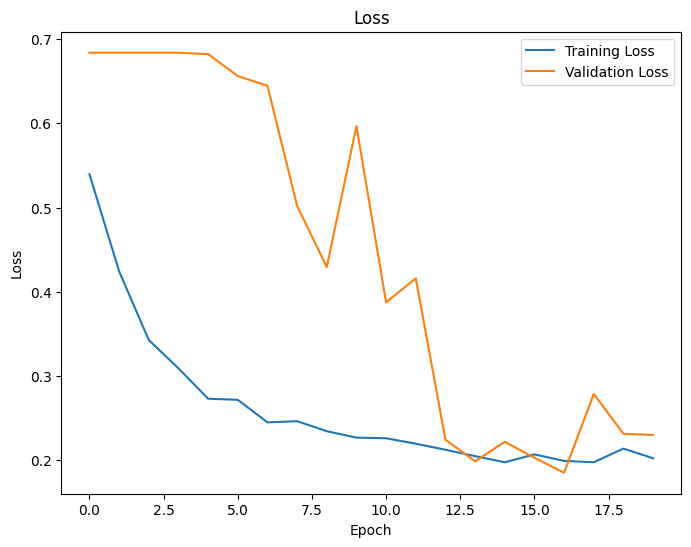

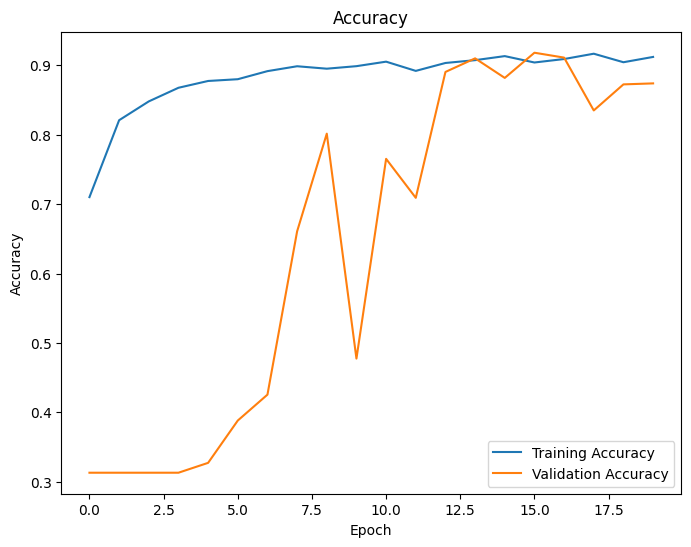

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already trained the model and obtained the `history` object

# Get the metrics from the history object
loss = hist.history['loss']
accuracy = hist.history['accuracy']
val_loss = hist.history['val_loss']
val_accuracy = hist.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

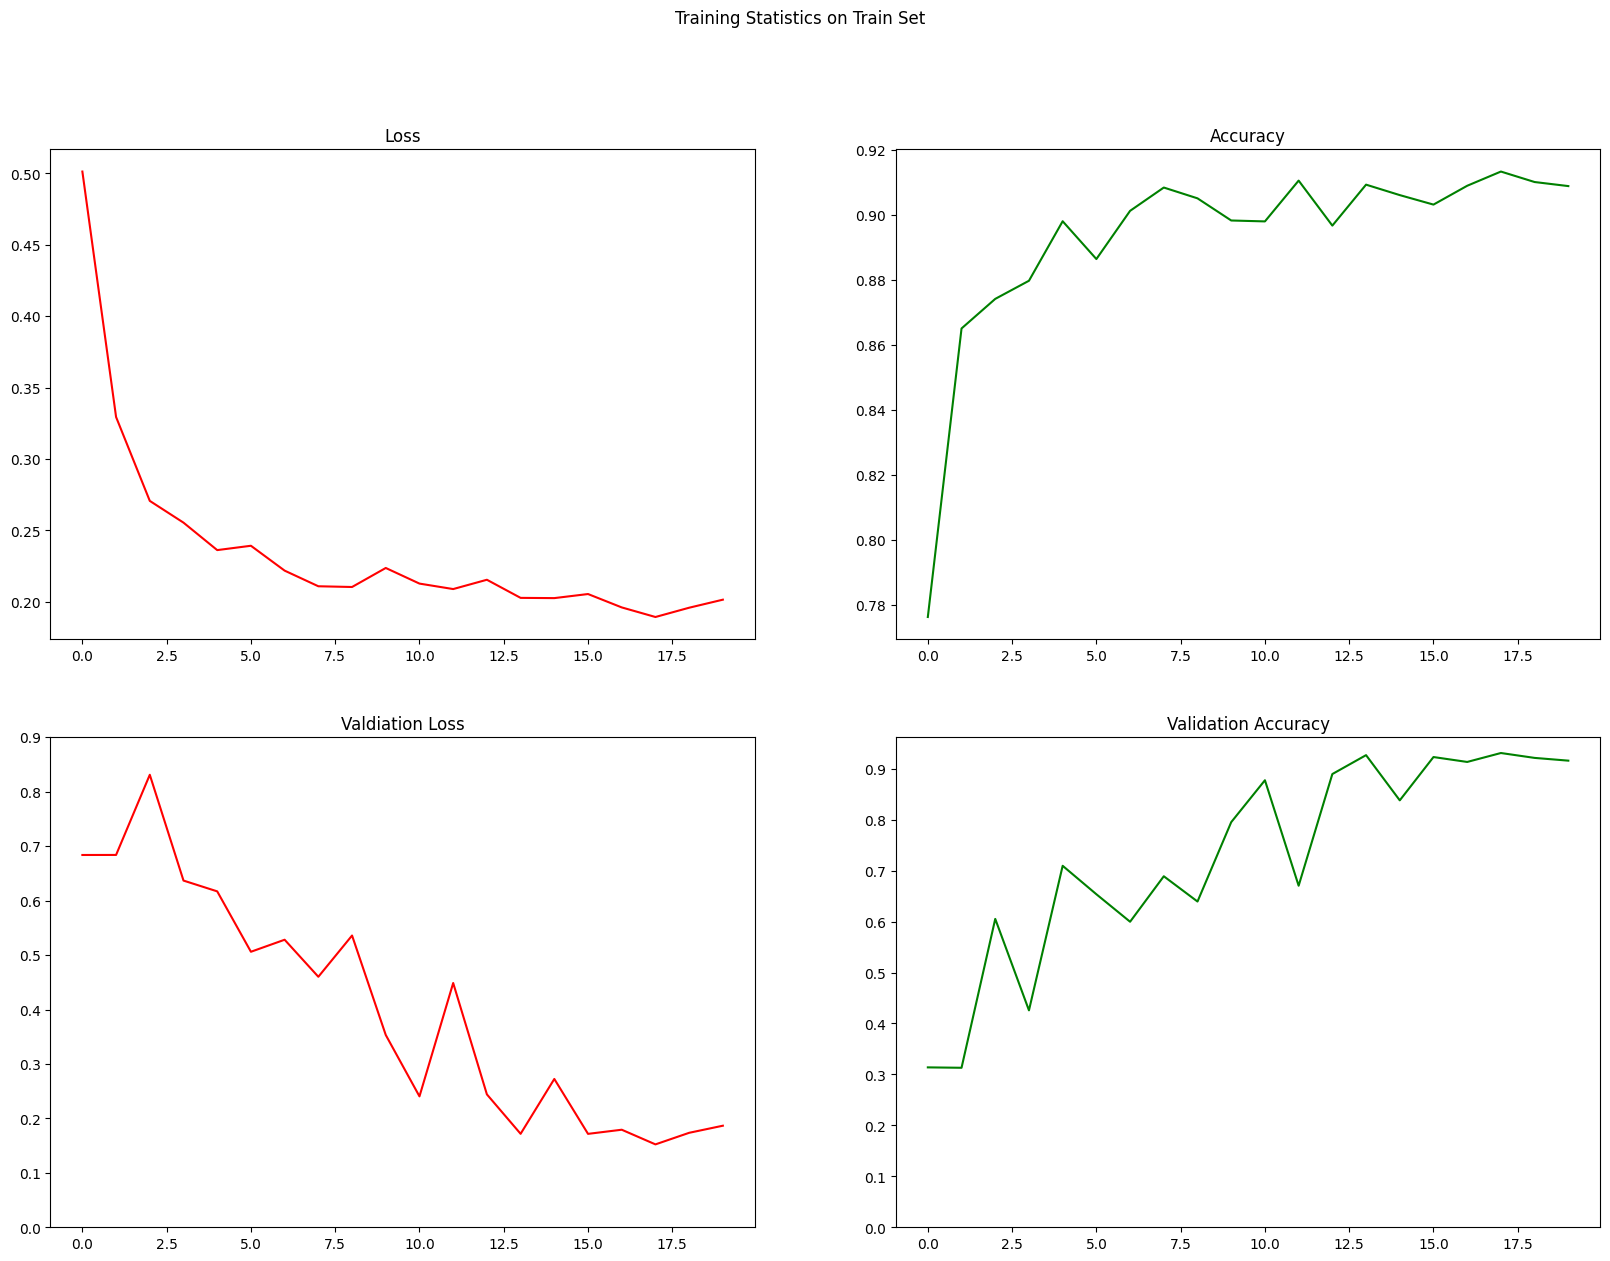

In [ ]:
plt.figure(figsize=(20, 14))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

1/1 [==============================] - 2s 2s/step


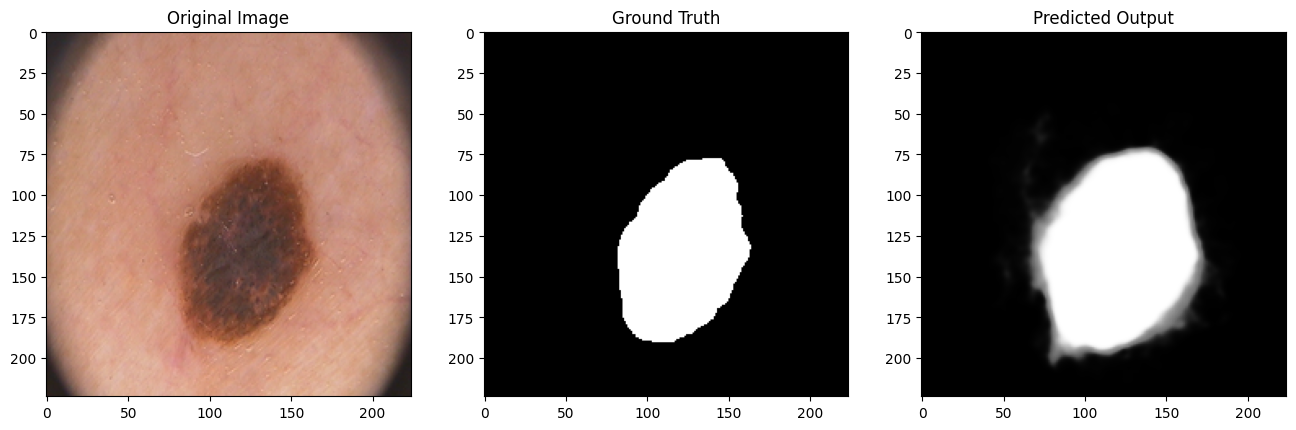

In [ ]:
img_num = 49
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 20ms/step


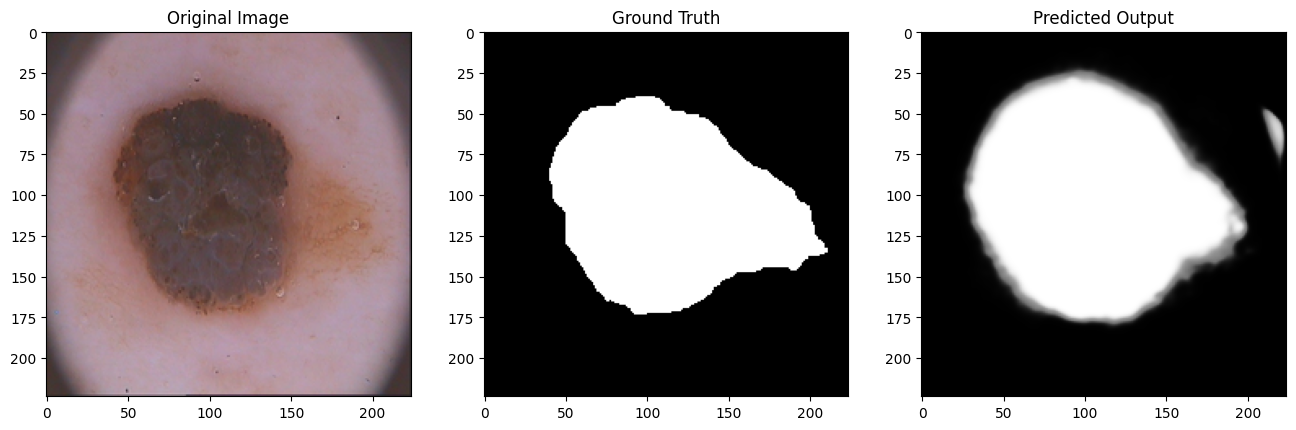

In [ ]:
img_num = 11
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 21ms/step


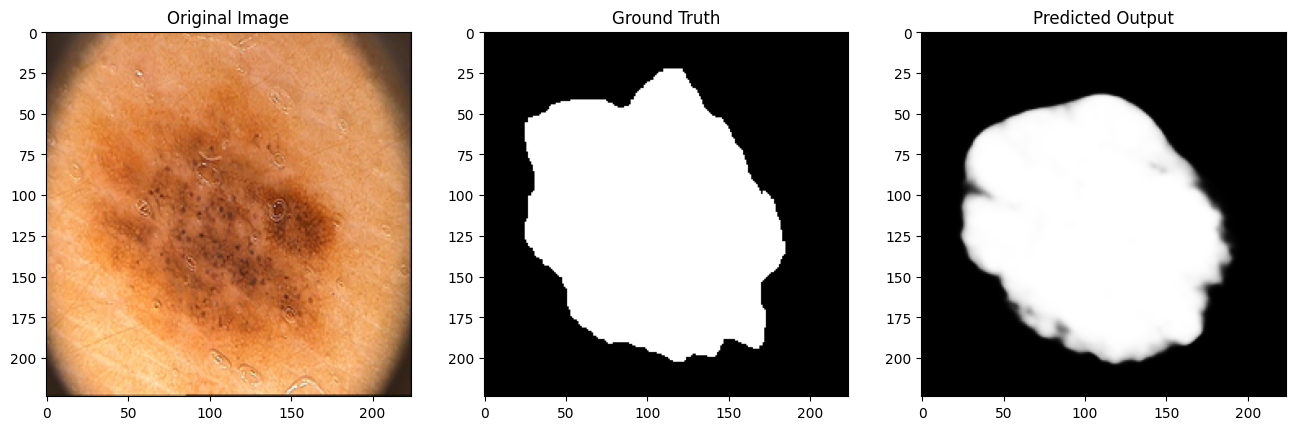

In [ ]:
img_num = 38
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 21ms/step


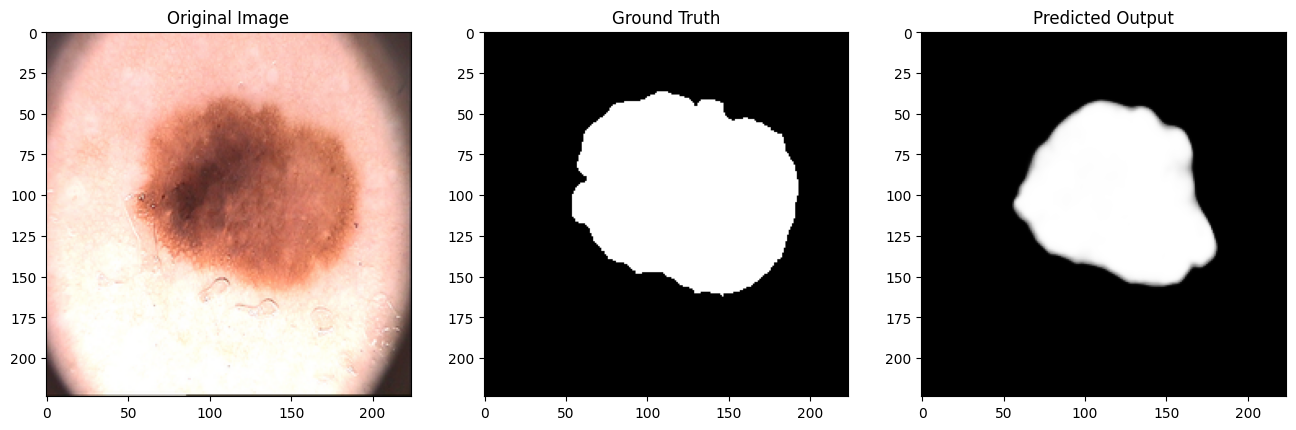

In [ ]:
img_num = 21
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

#Conclusion

In [ ]:
def enhance(img):
    sub = (model_1.predict(img.reshape(1,224,224,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

1/1 [==============================] - 0s 30ms/step


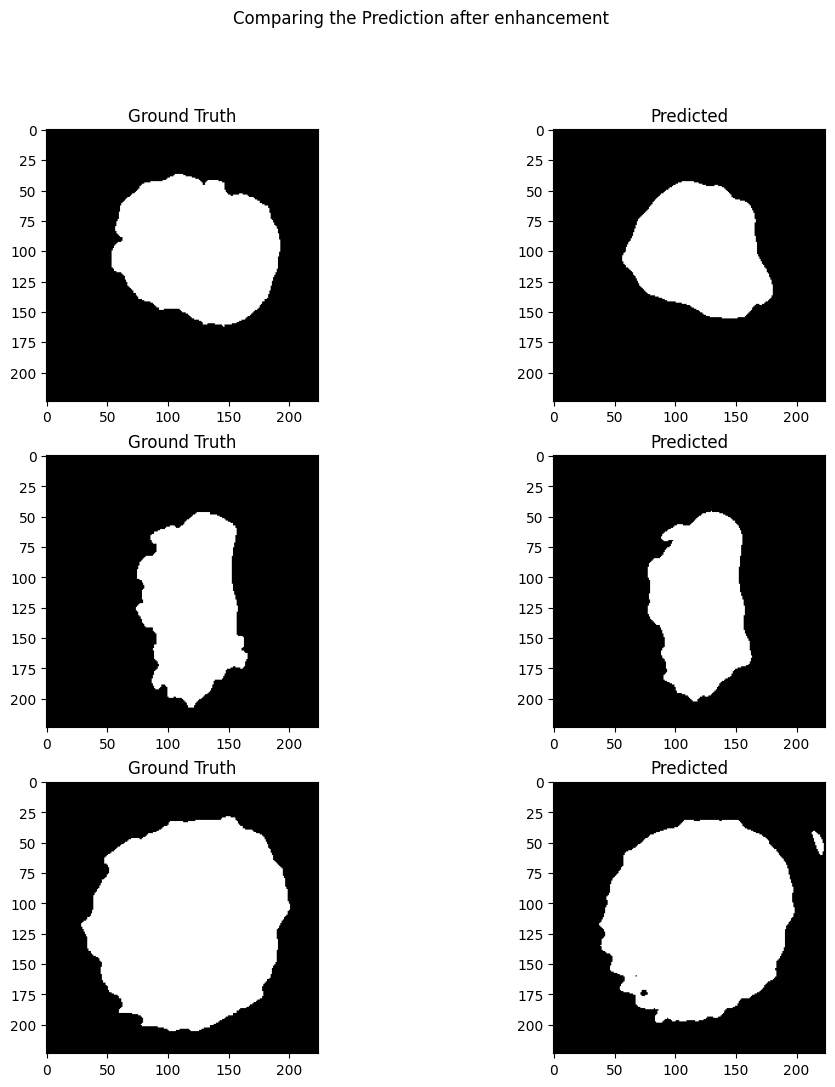

In [ ]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[21]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[47],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[47]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[36],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[36]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.show()

#Attention unet

In [ ]:
from tensorflow.keras import layers as L

def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    return x
def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p
def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s
def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x
def attention_unet(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """
    outputs = L.Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model
input_shape = (224,224,3)
model = attention_unet(input_shape)

In [ ]:
model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coeff, precision, recall, accuracy])

In [ ]:
model.summary()

Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_117 (Conv2D)         (None, 224, 224, 64)         1792      ['input_6[0][0]']             
                                                                                                  
 batch_normalization_106 (B  (None, 224, 224, 64)         256       ['conv2d_117[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_109 (Activation  (None, 224, 224, 64)         0         ['batch_normaliza

In [ ]:
hist = model.fit(x_train_full, y_train_full, epochs=20, batch_size=18, validation_data=(x_val, y_val), verbose=1)
hist

Epoch 1/20
25/25 [==============================] - 39s 1s/step - loss: 0.3631 - iou: 0.4761 - dice_coeff: 0.3958 - precision: 0.6945 - recall: 0.8232 - accuracy: 0.8171 - val_loss: 0.6839 - val_iou: 0.3161 - val_dice_coeff: 0.3054 - val_precision: 0.3131 - val_recall: 1.0000 - val_accuracy: 0.3131
Epoch 2/20
25/25 [==============================] - 27s 1s/step - loss: 0.2422 - iou: 0.5541 - dice_coeff: 0.4507 - precision: 0.7832 - recall: 0.8636 - accuracy: 0.8785 - val_loss: 0.6852 - val_iou: 0.3146 - val_dice_coeff: 0.3049 - val_precision: 0.3119 - val_recall: 0.9930 - val_accuracy: 0.3120
Epoch 3/20
25/25 [==============================] - 26s 1s/step - loss: 0.2168 - iou: 0.5984 - dice_coeff: 0.4857 - precision: 0.8146 - recall: 0.8753 - accuracy: 0.8931 - val_loss: 0.6835 - val_iou: 0.3164 - val_dice_coeff: 0.3056 - val_precision: 0.3138 - val_recall: 1.0000 - val_accuracy: 0.3154
Epoch 4/20
25/25 [==============================] - 26s 1s/step - loss: 0.1988 - iou: 0.6116 - dice_

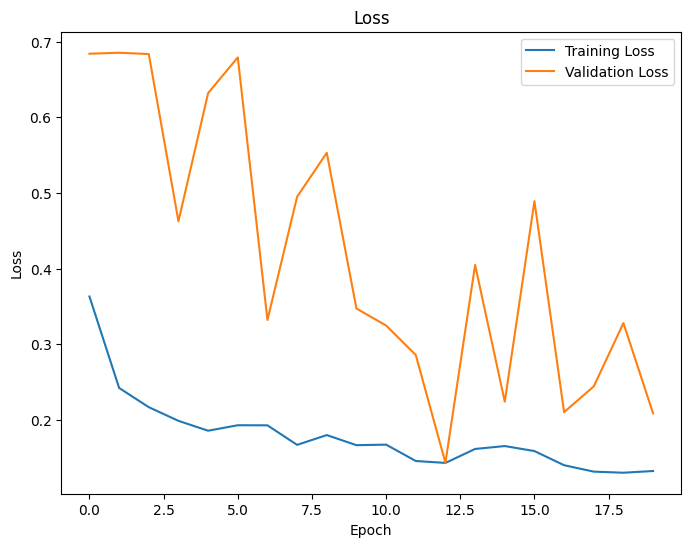

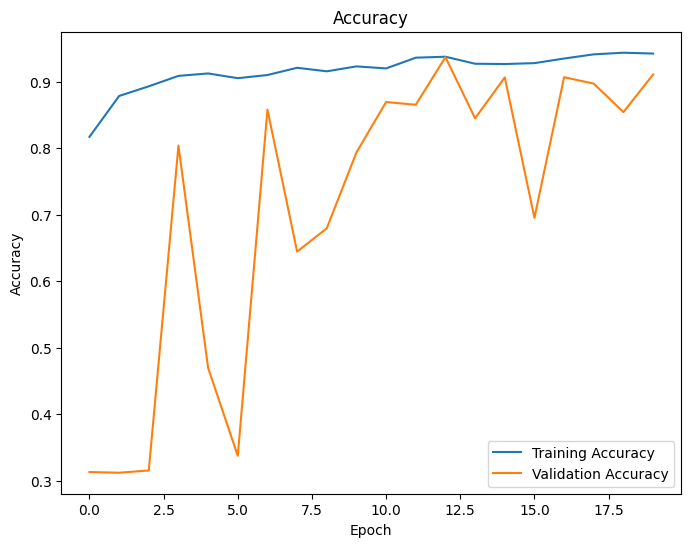

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already trained the model and obtained the `history` object

# Get the metrics from the history object
loss = hist.history['loss']
accuracy = hist.history['accuracy']
val_loss = hist.history['val_loss']
val_accuracy = hist.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
# Convert JSON to DataFrame
df = pd.DataFrame(hist.history)

# Print the DataFrame
print(df)

        loss       iou  dice_coeff  precision    recall  accuracy  val_loss  \
0   0.363061  0.476149    0.395823   0.694537  0.823150  0.817055  0.683883   
1   0.242225  0.554133    0.450738   0.783186  0.863552  0.878505  0.685230   
2   0.216825  0.598354    0.485723   0.814571  0.875276  0.893068  0.683456   
3   0.198752  0.611574    0.497874   0.852626  0.872116  0.908728  0.462418   
4   0.185718  0.629081    0.509381   0.869860  0.864442  0.912376  0.631891   
5   0.192938  0.654382    0.530638   0.845924  0.879146  0.905279  0.679048   
6   0.192832  0.647550    0.529285   0.868242  0.862025  0.909996  0.332048   
7   0.167014  0.683263    0.554564   0.879643  0.879031  0.920906  0.494836   
8   0.179971  0.668346    0.543656   0.888470  0.851443  0.915591  0.552956   
9   0.166585  0.694013    0.565146   0.893309  0.872570  0.923000  0.347180   
10  0.167332  0.701152    0.571684   0.885060  0.876806  0.919960  0.324712   
11  0.145693  0.714790    0.582164   0.926371  0.873

##Visualization

1/1 [==============================] - 0s 21ms/step


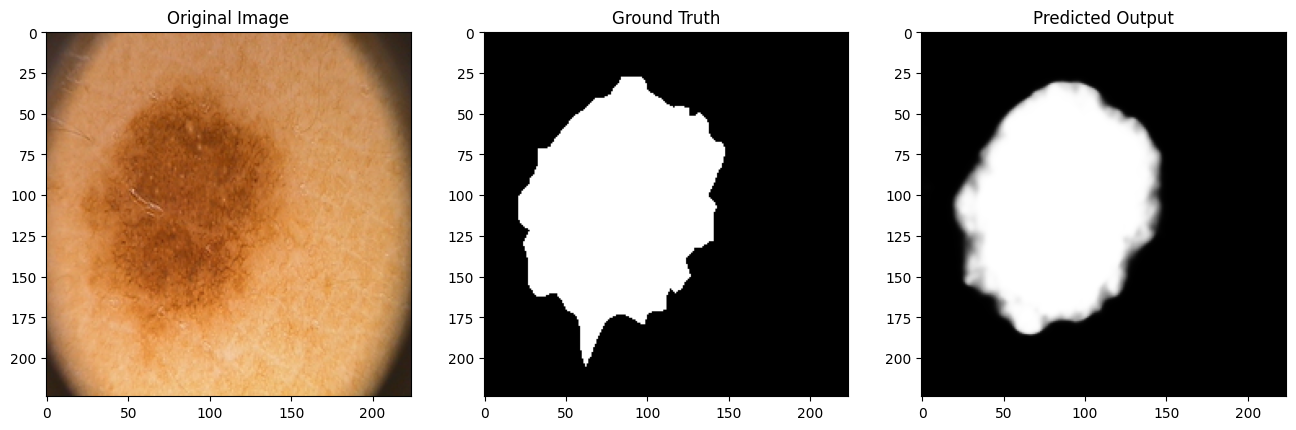

In [ ]:
img_num = 40
img_pred = model.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 22ms/step


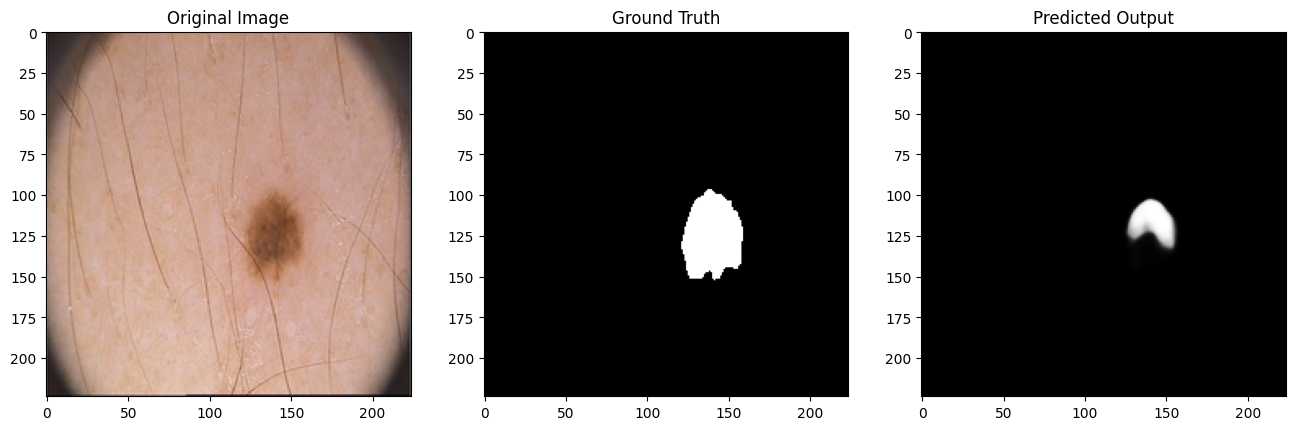

In [ ]:
img_num = 6
img_pred = model.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

#Conclusion for attention

In [ ]:
def enhance(img):
    sub = (model.predict(img.reshape(1,224,224,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

1/1 [==============================] - 0s 22ms/step


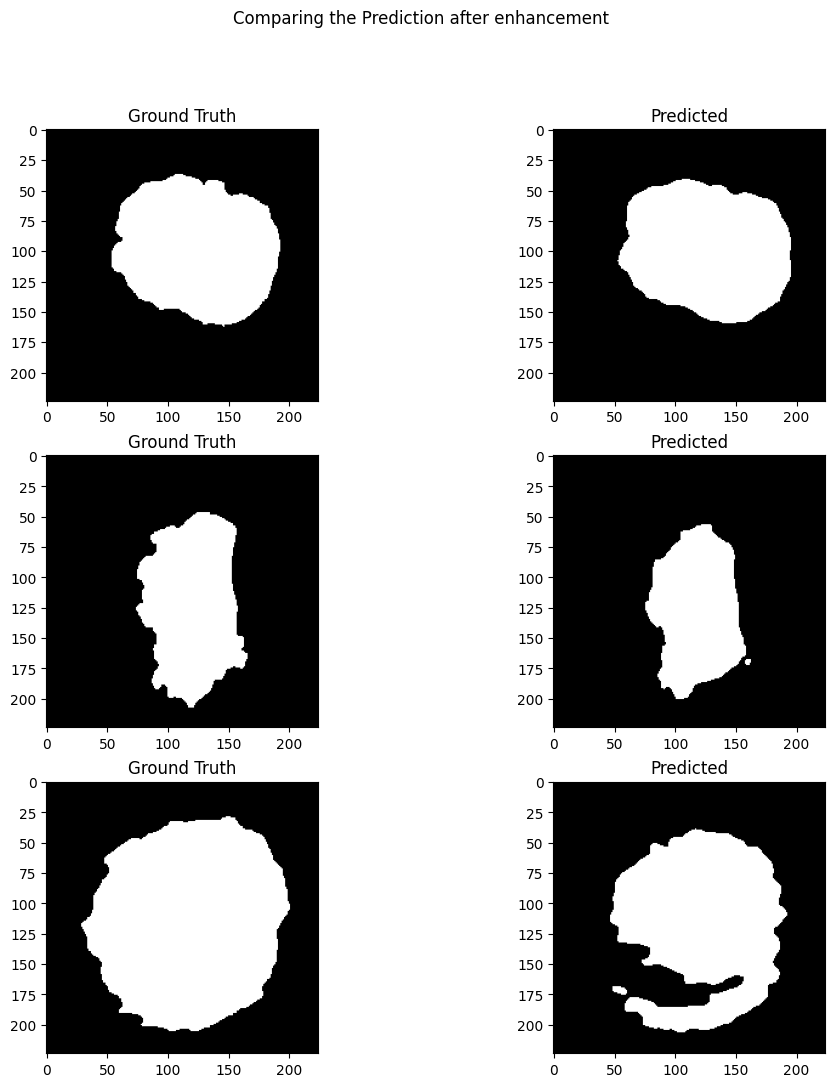

In [ ]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[21]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[47],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[47]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[36],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[36]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.show()